# Synthetic error injection

## Load the 3 grams dataset

In [1]:
import pandas as pd
import random
from tqdm import tqdm_notebook as tqdm

In [2]:
import sys
sys.path.insert(0, "../")

In [3]:
df = pd.read_csv('../three_grams.csv')
df.head(10)

,token_1,ws,token_2,count
0,Comment,1_NL,Comment,3282
1,Comment,1_NL,package,492
2,package,1_SP,Identifier,2083
3,Identifier,0_SP,.,135330
4,.,0_SP,Identifier,146617
5,Identifier,0_SP,;,28148
6,;,1_NL,EOF,4
7,;,2_NL,import,2961
8,import,1_SP,Identifier,15630
9,;,1_NL,import,13795


In [4]:
count_df = df.loc[:,['token_1', 'token_2', 'count']].groupby(['token_1', 'token_2']).agg(['count', 'sum'])

In [5]:
count = count_df['count']['count']
good_for_insertion = list(count[count>=2].index)

In [6]:
good_for_insertion_index = []
for index, (token_1, token_2) in df.loc[:,['token_1', 'token_2']].iterrows():
    if (token_1, token_2) in good_for_insertion:
        good_for_insertion_index.append(index)

In [7]:
good_for_insertion_df = df.iloc[good_for_insertion_index ,:]

In [8]:
good_for_insertion_set = set(
    good_for_insertion
)
def is_good_for_insertion(token_a, token_b):
    return (token_a, token_b) in good_for_insertion_set

In [9]:
def list_alternatives_with_probability(token_a, ws, token_b):
    df_token_1 = good_for_insertion_df[good_for_insertion_df.token_1 == token_a]
    df_token_1_and_2 = df_token_1[df_token_1.token_2 == token_b]
    final = df_token_1_and_2[df_token_1_and_2.ws != ws]
    total = final['count'].sum()
    return {
        ws:count/total
        for _, (_, ws, _, count) in final.iterrows()
    }

In [10]:
list_alternatives_with_probability('Comment', '1_NL', 'Comment')

{'2_NL': 0.6451612903225806,
 '2_NL_4_ID': 0.13978494623655913,
 '1_NL_8_ID': 0.010752688172043012,
 '3_NL': 0.010752688172043012,
 '1_NL_16_DD': 0.010752688172043012,
 '1_NL_4_DD': 0.053763440860215055,
 '2_NL_4_DD': 0.03225806451612903,
 '1_NL_8_DD': 0.03225806451612903,
 '2_NL_8_ID': 0.010752688172043012,
 '2_NL_8_DD': 0.010752688172043012,
 '1_NL_12_ID': 0.010752688172043012,
 '1_NL_2_ID': 0.010752688172043012,
 '1_NL_50_ID': 0.021505376344086023}

## Generation of a new source 

In [11]:
import java_lang_utils as jlu
from core import *

In [12]:
from ml import get_token_value, get_space_value
from token_utils import whitespace_token_to_tuple

In [13]:
from Corpus import Corpus

In [14]:
corpus = Corpus('../corpora/repairnator-corpus/', 'repairnator')

In [15]:
tokenizer = jlu.Tokenizer()
tokenizer_absolute = jlu.Tokenizer(relative=False)

In [16]:
file_dir = corpus.files[10][2]
file_dir

'../corpora/repairnator-corpus/data/51/MavenHelper.java'

In [17]:
original_source = open_file(file_dir)

In [18]:
def pick_random(alternatives):
    random_number = random.random()
    probability_sum = 0
    for alternative, probability in alternatives.items():
        probability_sum += probability
        if random_number <= probability_sum:
            return alternative
    return None

In [19]:
def get_line_indent(line):
    indent = 0
    for c in line:
        if c == ' ':
            indent+=1
        else:
            return indent

In [20]:
def modify_source(source, n_insertion=1):
    tokenized_source = tokenizer.tokenize(source)
    tokenized_source_absolute = tokenizer_absolute.tokenize(source)
    insertion_spots = list(range(len(tokenized_source.tokens)-1))
    random.shuffle(insertion_spots)
    modification = None
    for spot in insertion_spots:
        token_a = tokenized_source.tokens[spot]
        token_b = tokenized_source.tokens[spot+1]
        ws = tokenized_source.white_spaces[spot]
        if is_good_for_insertion(get_token_value(token_a), get_token_value(token_b)):
            alternatives = list_alternatives_with_probability(
                get_token_value(token_a),
                get_space_value(ws),
                get_token_value(token_b)
            )
            alternative_selected = pick_random(alternatives)
            alternative_selected_tuple = whitespace_token_to_tuple(alternative_selected)
            new_ws = tokenized_source_absolute.white_spaces[spot]
            if alternative_selected_tuple[0] == 0:
                new_ws = alternative_selected_tuple
            elif alternative_selected_tuple[0] != 0 and new_ws[0] == 0:
                line = token_a.position[0]
                indent = get_line_indent(source.split('\n')[line-1])
                new_ws = (alternative_selected_tuple[0], indent + alternative_selected_tuple[1])
            else:
                new_ws = (alternative_selected_tuple[0], new_ws[1] + (alternative_selected_tuple[1] - ws[1]))
            if new_ws[1]>=0:
                tokenized_source_absolute.white_spaces[spot] = new_ws
                modification = {
                    'token_a': get_token_value(token_a),
                    'token_b': get_token_value(token_b),
                    'modification': (get_space_value(ws), alternative_selected),
                    'position': spot
                }
                break
    return tokenized_source_absolute.reformat(), modification

In [21]:
t = tokenizer_absolute.tokenize(original_source)

In [57]:
def diff(file_A, file_B, context=False):
    if context:
        cmd = 'diff -c {} {}'.format(file_A, file_B)
    else:
        cmd = 'diff {} {}'.format(file_A, file_B)
    process = subprocess.Popen(cmd.split(" "), stdout=subprocess.PIPE)
    output = process.communicate()[0]
    return output.decode("utf-8")

In [48]:
modified_source, _ = modify_source(original_source)
file_A = save_file('./tmp/', 'orig.java', original_source)
file_B = save_file('./tmp/', 'modif.java', modified_source)
print(diff(file_A, file_B))

*** ./tmp/orig.java	2019-10-03 10:31:11.000000000 -0400
--- ./tmp/modif.java	2019-10-03 10:31:11.000000000 -0400
***************
*** 85,91 ****
          request.setGoals(Arrays.asList(this.goal));
  
          if (properties == null) {
!             properties = new Properties();
          }
  
          properties.setProperty("maven.repo.local", this.inspector.getM2LocalPath());
--- 85,92 ----
          request.setGoals(Arrays.asList(this.goal));
  
          if (properties == null) {
!             properties
!                 = new Properties();
          }
  
          properties.setProperty("maven.repo.local", this.inspector.getM2LocalPath());



## Generation of errors

### Batches

In [49]:
import uuid
import checkstyle

In [50]:
corpus_name = 'repairnator'

In [51]:
corpus = Corpus(f'../corpora/{corpus_name}-corpus/', corpus_name)
BATCH_SIZE = 500

In [52]:
share = {
    'learning': 8000,
    'validation': 1000,
    'testing': 1000
}

In [53]:
def split_files(corpus, share, random_state=100):
    files_list = [file for (_,_,file) in corpus.files.values()]
    random.seed(random_state)
    random.shuffle(files_list)
    return {
        'learning': files_list[:share['learning']],
        'validation': files_list[share['learning']: share['learning']+share['validation']],
        'testing': files_list[share['learning']+share['validation']:]
    }

In [58]:
def gen_batch(files_dir, checkstyle_dir, batch_id=None):
    if batch_id == None:
        batch_id = uuid.uuid4().hex
    batch_dir = f'./tmp/{batch_id}'
    create_dir(batch_dir)
    batch_files = [ random.choice(files_dir) for _ in range(BATCH_SIZE)]
    batch_information = {}
    for index, file_dir in tqdm(enumerate(batch_files), total=BATCH_SIZE):
        file_name = file_dir.split('/')[-1]
        original_source = open_file(file_dir)
        modified_source, modification = modify_source(original_source)
        modification_folder = os.path.join(batch_dir, str(index))
        create_dir(modification_folder)
        modified_file_dir = save_file(modification_folder, file_name, modified_source)
        diff_str = diff(file_dir, modified_file_dir, context=True)
        diff_path = save_file(modification_folder, 'diff.diff', diff_str)
        batch_information[index] = {
            'modification': modification,
            'diff': diff_str,
            'dir': modification_folder
        }
    checkstyle_result, _ = checkstyle.check(
        checkstyle_dir,
        batch_dir,
        checkstyle_jar="../../jars/checkstyle-8.12-all.jar",
        only_java=True
    )
    for file_dir, res in checkstyle_result.items():
        index = int(file_dir.split('/')[-2])
        batch_information[index]['errors'] = res['errors']
        save_json(batch_information[index]['dir'], 'errors.json', res['errors'])
    save_json(batch_dir, 'metadata.json', batch_information)
    return {
        'batch_id': batch_id,
        'injection_report': batch_information
    }

In [59]:
corpus.checkstyle

'../corpora/repairnator-corpus/checkstyle.xml'

In [60]:
batch_res = gen_batch(split_files(corpus, share)['learning'], corpus.checkstyle)

100%|██████████| 500/500 [00:11<00:00, 45.08it/s]


In [61]:
errors_type = [
    info['errors'][0]['source'].split('.')[-1] 
    for info in batch_res['injection_report'].values() 
    if len(info['errors']) == 1
]

In [62]:
print(f'total number of files with a single errors {len(errors_type)} ()')

total number of files with a single errors 175 ()


In [63]:
from collections import Counter

In [64]:
error_type_count = Counter(errors_type)
error_type_count

Counter({'IndentationCheck': 142,
         'LeftCurlyCheck': 22,
         'NeedBracesCheck': 9,
         'RightCurlyCheck': 2})

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

In [66]:
col_names, values = tuple(zip(*list(error_type_count.items())))

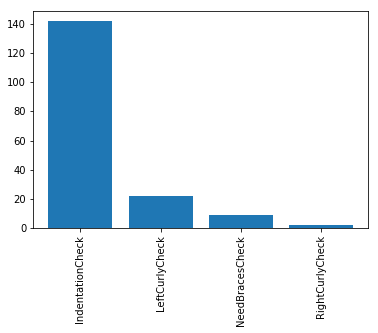

In [67]:
fig = plt.figure()

y_pos = list(range((len(col_names))))

plt.bar(y_pos, values)

plt.xticks(y_pos, col_names,rotation='vertical')

plt.show()

### Dataset

In [ ]:
def gen_dataset(files_dir, checkstyle_dir, target, number_of_errors):
    valid_errors = []
    while len(valid_errors) < number_of_errors:
        batch_res = gen_batch(split_files(corpus, share)['learning'], corpus.checkstyle)
        